In [290]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from typing import List, Callable
# import tensorflow as tf
# from tensorflow.keras import layers


# matplotlib.font_manager._rebuild()
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
sns.set(font="Malgun Gothic",rc={"axes.unicode_minus":False}, style='whitegrid')

In [291]:
data_root = "./data/daily"

## 1. Data 준비

### 1) Weather data

In [292]:
# load each data
temp_df = pd.read_csv(f'{data_root}/Temperatures.csv', encoding='cp949')
precip_df = pd.read_csv(f'{data_root}/Precipitation.csv', encoding='cp949').fillna(0)
wind_df = pd.read_csv(f'{data_root}/Wind.csv', encoding='cp949')
humidity_df = pd.read_csv(f'{data_root}/Humidity.csv', encoding='cp949')
sunshine_df = pd.read_csv(f'{data_root}/Sunshine.csv', encoding='cp949')

# merge
weather_df = temp_df.merge(precip_df).merge(wind_df).merge(humidity_df).merge(sunshine_df)
weather_columns = ["평균기온", "강수량mm", "평균풍속ms", "평균습도rh","일조합"]

selected_weather_df = weather_df[['일시']+weather_columns]
display(selected_weather_df.head(3))

,일시,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합
0,2012-01-01,-3.0,0.0,2.9,64.5,4.4
1,2012-01-02,-4.8,0.0,2.3,66.5,5.9
2,2012-01-03,-4.5,0.4,2.5,68.3,2.7


### 2) Stock data

In [293]:
# company_name = "Samsung Electronics Co"
company_name = "Amorepacific Corporation"
stock_price_df = pd.read_csv(f'./data/stock/{company_name}.csv')
stock_columns = ['Close']
selected_stock_df = stock_price_df[['Date'] + stock_columns].dropna()
display(selected_stock_df.head(3))

,Date,Close
0,2006-06-29,39200.0
1,2006-06-30,40900.0
2,2006-07-03,41400.0


### 3) Merge

In [294]:
stock_weather_df = selected_weather_df.rename(columns={"일시":"Date"}).merge(selected_stock_df)
display(stock_weather_df)

,Date,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,Close
0,2012-01-02,-4.8,0.0,2.3,66.5,5.9,104900.0
1,2012-01-03,-4.5,0.4,2.5,68.3,2.7,108000.0
2,2012-01-04,-7.4,0.0,3.1,55.4,8.1,107000.0
3,2012-01-05,-5.7,0.0,1.5,49.8,9.0,106600.0
4,2012-01-06,-2.8,0.0,2.5,42.9,8.4,105000.0
...,...,...,...,...,...,...,...
2553,2022-05-20,20.6,0.0,2.3,52.8,10.8,153500.0
2554,2022-05-23,23.0,0.0,2.3,63.5,10.4,158000.0
2555,2022-05-24,22.9,0.0,2.1,56.8,12.3,155000.0
2556,2022-05-25,21.0,3.5,2.6,66.6,8.1,157000.0


In [295]:
display(stock_weather_df.isnull().sum())
display(stock_weather_df[stock_weather_df['평균풍속ms'].isnull()])
display(stock_weather_df[stock_weather_df['일조합'].isnull()])
stock_weather_df = stock_weather_df.dropna()

Date      0
평균기온      0
강수량mm     0
평균풍속ms    2
평균습도rh    0
일조합       9
Close     0
dtype: int64

,Date,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,Close
1460,2017-12-05,-4.2,0.1,NaN,40.1,2.1,336500.0
1461,2017-12-06,0.2,1.2,NaN,72.6,7.7,333000.0


,Date,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,Close
1418,2017-09-28,19.2,0.0,2.8,49.1,NaN,252000.0
1422,2017-10-12,11.4,0.0,2.0,71.0,NaN,254500.0
1449,2017-11-20,-0.4,0.0,1.4,55.3,NaN,318000.0
1454,2017-11-27,2.5,0.0,1.3,53.0,NaN,316000.0
1457,2017-11-30,-2.4,0.0,3.3,26.8,NaN,309000.0
1488,2018-01-18,2.1,0.0,1.9,59.6,NaN,307500.0
1494,2018-01-26,-14.8,0.0,2.6,34.9,NaN,312000.0
1882,2019-08-28,26.1,0.0,1.9,66.2,NaN,123500.0
2217,2021-01-07,-14.5,0.0,4.1,49.9,NaN,200000.0


## 2. Training

In [296]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StockModel(nn.Module):
    def __init__(self, input_dim, t_dim, h_c=256, num_layers=2):
        super(StockModel, self).__init__()
        self.input_dim = input_dim
        self.t_dim = t_dim

        self.rnn = nn.GRU(input_size=input_dim, hidden_size=h_c, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=h_c, out_features=1)

    def forward(self, x):
        output, hn = self.rnn(x)
        return self.fc(output[:, -1, :]) # batch, last_cell, out_dim


### 2) Dataloader

In [297]:
from torch.utils.data import DataLoader, Dataset

class StockDataset(Dataset):
    def __init__(self, df, t_dim, label:List = None,):
        super(StockDataset, self).__init__()
        self.df = df.reset_index(drop=True)
        self.t_dim = t_dim
        if label is None:
            label = df.columns
        self.label = label
        self.total_length = len(df) - (t_dim + 1)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        x = self.df.loc[idx: idx+self.t_dim-1].values[:, :-1]
        y = self.df.loc[idx+self.t_dim][self.label].values
        return x, y
# preprocess
# log
stock_weather_df['Close'] = np.log(1+stock_weather_df['Close'])
train_df = stock_weather_df[stock_weather_df['Date'] < '2019-01-01'].drop(columns='Date')
test_df = stock_weather_df[stock_weather_df['Date'] >= '2019-01-01'].drop(columns='Date')
StockDataset(test_df, t_dim=25)

train_mean, train_std = train_df.mean(), train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

display(train_df.head(3), test_df.head(3))

,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,Close
0,-1.629816,-0.277132,-0.197953,0.495884,-0.243045,-1.257278
1,-1.602524,-0.242688,0.032454,0.618388,-1.057091,-1.204490
2,-1.866350,-0.277132,0.723674,-0.259559,0.316611,-1.221351


,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,Close
1720,-1.638914,-0.277132,-0.889174,-1.117088,0.469245,-0.147517
1721,-1.511549,-0.277132,-1.234785,-1.389320,0.469245,-0.138174
1722,-1.293210,-0.277132,-1.465192,-0.252753,-0.751824,-0.219168


In [298]:
def train(model, train_loader, criterion, optimizer, epochs=10, device=torch.device('cpu'), valid_loader=None):
    model = model.to(device)
    for epoch in range(epochs):
        running_loss = 0
        # train
        for step, (x, y) in enumerate(train_loader):
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad()

            pred = model(x)
            loss =criterion(pred, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (step+1) % 100 == 0:
                print(f"{epoch+1} epoch : {step+1 :5d}step - loss={running_loss/(step+1)}")
        print(f"{epoch+1} epoch : {step+1 :5d}step - loss={running_loss/(step+1)}")

        # valid
        if valid_loader is not None:
            valid_loss = 0
            for step, (x, y) in enumerate(valid_loader):
                x, y = x.float().to(device), y.float().to(device)
                pred = model(x)
                pred = torch.exp(pred) + 1
                y = torch.exp(y) + 1
                valid_loss += mean_absolute_percentage_error(y.detach().cpu().numpy().squeeze(),
                                                             pred.detach().cpu().numpy().squeeze())
            print(f"valid_loss={valid_loss}")

    return model

In [299]:
# config
batch_size = 32
t_dim = 24  # todo: 변수명 변경 필요..
input_dim = len(weather_columns) + len(stock_columns)
epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Train using only stock price data

In [300]:
# model
stock_model = StockModel(1, t_dim=t_dim) # input_dim=1: [stock price value]
# dataloader
train_ds = StockDataset(train_df[['Close']], t_dim=t_dim, label=['Close'])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_ds = StockDataset(test_df[['Close']], t_dim=t_dim, label=['Close'])
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
# loss, optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(stock_model.parameters(), lr=0.001)
# train
model = train(stock_model, train_loader, criterion, optimizer, epochs, device=device,
              valid_loader=valid_loader)

1 epoch :    53step - loss=0.08229898606462158
valid_loss=0.6219539567828178
2 epoch :    53step - loss=0.003178095040878035
valid_loss=0.5731786722317338
3 epoch :    53step - loss=0.0027914710566928646
valid_loss=0.5154741490259767
4 epoch :    53step - loss=0.00245392755693141
valid_loss=0.48875144124031067
5 epoch :    53step - loss=0.0023933872492667638
valid_loss=0.48484739661216736
6 epoch :    53step - loss=0.0021536593349597787
valid_loss=0.43403896503150463
7 epoch :    53step - loss=0.002085773869558185
valid_loss=0.49004246201366186
8 epoch :    53step - loss=0.0023089927085235998
valid_loss=0.4135010167956352
9 epoch :    53step - loss=0.0019409613275267886
valid_loss=0.4012739546597004
10 epoch :    53step - loss=0.0020493539511489698
valid_loss=0.39652347937226295


In [301]:
model_y_pred = []
model_y_true = []
temp = (0,0)
model.eval()
for x, y in DataLoader(valid_ds, batch_size=1):
    y_pred = model(x.float().to(device))
    model_y_pred.append(y_pred.detach().cpu().numpy())
    model_y_true.append(y.detach().cpu().numpy())

In [302]:
import math
test_y_pred = np.exp(np.concatenate(model_y_pred)).squeeze() +1
test_y_true = np.exp(np.concatenate(model_y_true)).squeeze() + 1


testScore = math.sqrt(mean_absolute_percentage_error(test_y_true, test_y_pred))
print(f'Test Score: {testScore*100:.3f}% MAPE')

Test Score: 12.397% MAPE


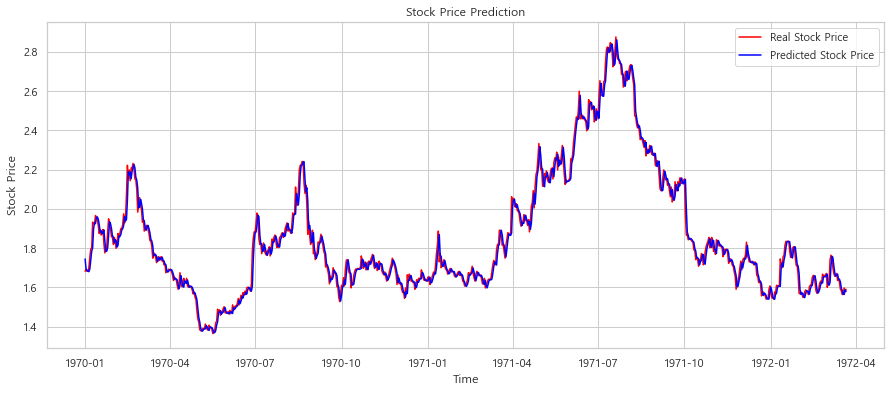

In [303]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(np.arange(len(test_y_true)), test_y_true, color = 'red', label = 'Real Stock Price')
axes.plot(np.arange(len(test_y_true)), test_y_pred, color = 'blue', label = 'Predicted Stock Price')
# axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()

Train stock price & weather data

In [304]:
model = StockModel(input_dim-1, t_dim)

train_ds = StockDataset(train_df, t_dim=t_dim, label=['Close'])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_ds = StockDataset(test_df, t_dim=t_dim, label=['Close'])
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, epochs, device=device,
              valid_loader=valid_loader)

1 epoch :    53step - loss=0.07757510171482726
valid_loss=0.6876149643212557
2 epoch :    53step - loss=0.003734837349873247
valid_loss=0.5972561091184616
3 epoch :    53step - loss=0.003565470828622017
valid_loss=0.6108491895720363
4 epoch :    53step - loss=0.0033453024027623097
valid_loss=0.5914569273591042
5 epoch :    53step - loss=0.003305082325823605
valid_loss=0.5763325076550245
6 epoch :    53step - loss=0.0033714392503618068
valid_loss=0.5544543014839292
7 epoch :    53step - loss=0.0030645605941074638
valid_loss=0.5602529365569353
8 epoch :    53step - loss=0.0027815563371405005
valid_loss=0.7173320278525352
9 epoch :    53step - loss=0.002967415131487936
valid_loss=0.5741777587682009
10 epoch :    53step - loss=0.0025441803143553014
valid_loss=0.49868022184818983


In [305]:
model_y_pred = []
model_y_true = []
temp = (0,0)
model.eval()
for x, y in DataLoader(valid_ds, batch_size=1):
    y_pred = model(x.float().to(device))
    model_y_pred.append(y_pred.detach().cpu().numpy())
    model_y_true.append(y.detach().cpu().numpy())

In [306]:
test_y_pred = np.exp(np.concatenate(model_y_pred)).squeeze() +1
test_y_true = np.exp(np.concatenate(model_y_true)).squeeze() + 1


testScore = math.sqrt(mean_absolute_percentage_error(test_y_true, test_y_pred))
print(f'Test Score: {testScore*100:.3f}% MAPE')

Test Score: 13.802% MAPE


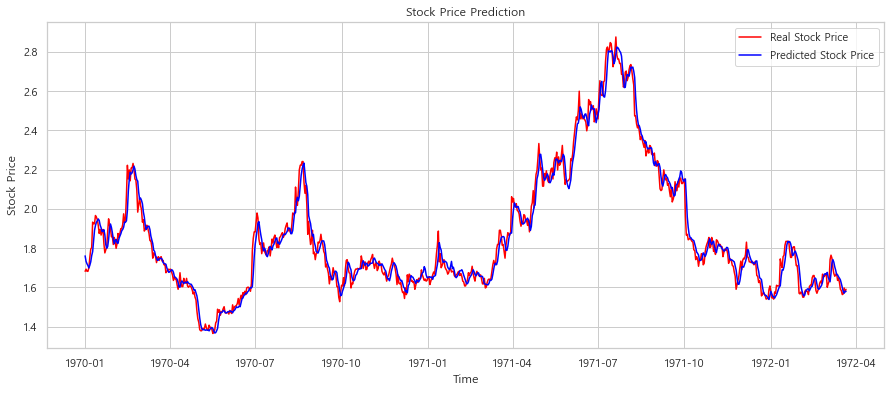

In [307]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(np.arange(len(test_y_true)), test_y_true, color = 'red', label = 'Real Stock Price')
axes.plot(np.arange(len(test_y_true)), test_y_pred, color = 'blue', label = 'Predicted Stock Price')
# axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()